In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7"
import json
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
import argparse 
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import matplotlib.pyplot as plt

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        "pretrained/Qwen2.5-VL-3B-Instruct",
        torch_dtype=torch.bfloat16,
        # attn_implementation="flash_attention_2",
        attn_implementation="eager",
        device_map="auto",
    )

# default processor
processor = AutoProcessor.from_pretrained("pretrained/Qwen2.5-VL-3B-Instruct")

/data_all/cjj_node/vit/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [2]:
img_path = "demo_images/catdog.png"
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": img_path,
                "resized_height": 224,
                "resized_width": 224, # 至少要(560 / 28) ** 2 = 400个token
            },
            {"type": "text", "text": "Find the dog in figure"},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, 
    tokenize=False, 
    add_generation_prompt=True,
    enable_thinking = True, # 设置思考
)

image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

# 添加可选参数，获取返回的attentions
inputs['output_attentions'] = True
for keys in inputs.keys():
    print(keys)
inputs = inputs.to(model.device)

input_ids
attention_mask
pixel_values
image_grid_thw
output_attentions


In [3]:
outputs,vit_attns = model(**inputs)

In [4]:
vl_attns = outputs.attentions

In [5]:
print(len(vit_attns))
print(len(vl_attns))

32
36


In [6]:
last_vit_attn = vit_attns[-1]
print(last_vit_attn.shape)

torch.Size([1, 16, 256, 256])


In [7]:
last_vl_attn = vl_attns[-1]
print(last_vl_attn.shape)

torch.Size([1, 16, 90, 90])


In [8]:
input_ids = inputs['input_ids']
print(input_ids)
print(input_ids.shape)
print("\n")
print(text)

tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151653,   9885,
            279,   5562,    304,   7071, 151645,    198, 151644,  77091,    198]],
       device='cuda:0')
torch.Size([1, 90])


<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Find the dog in figure<|

In [9]:
image_token = 151655
attn_token = 5562
img_token_mask = (input_ids == image_token)
img_token_positions = torch.nonzero(img_token_mask, as_tuple=True)[1]
attn_idx = (input_ids == attn_token).nonzero(as_tuple=True)[1].item()
print(img_token_positions)
print(img_token_positions.shape)
print(attn_idx)

tensor([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78], device='cuda:0')
torch.Size([64])
82


**一、cls token对应的图注意力(language-model的注意力图)**

In [10]:
import torchvision
import numpy as np
from torch import nn

def visualize_attention(img, attentions, attn_idx, img_token_idx, patch_size = 28):
    """img不带batch维度"""

    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    nh = attentions.shape[1]  # number of head

    # keep only the output patch attention
    attentions = attentions[0, :, attn_idx, img_token_idx].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)

    # attentions = nn.functional.interpolate(attentions.unsqueeze(
    #     0), scale_factor=patch_size, mode="nearest")[0].cpu().detach().numpy()

    attentions = nn.functional.interpolate(attentions.unsqueeze(
         0), scale_factor=patch_size, mode="bilinear")[0].cpu().detach().numpy()

    return attentions

def plot_attention(img, attention, idx = -1):
    n_heads = attention.shape[0]

    plt.figure(figsize=(10, 10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot((n_heads + 2)//3, 3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    if idx != -1:
        plt.savefig(f"temp/demo_{idx}.jpg")
    plt.show()

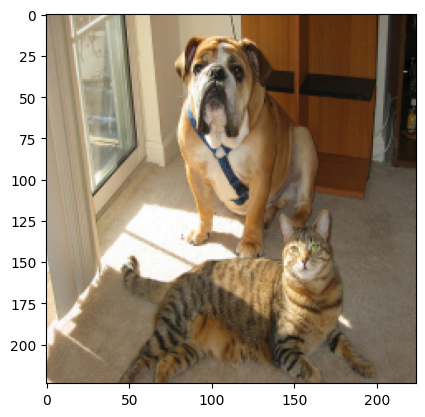

In [11]:
import cv2
img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# img = cv2.resize(img,(448,448))
img = torch.tensor(img).permute(2,0,1)
plt.imshow(img.permute(1,2,0))

In [12]:
show_attens = visualize_attention(img,last_vl_attn.to(torch.float32),attn_idx,img_token_positions)

In [13]:
temp = np.mean(show_attens, 0)
print(temp.shape)
print(temp.max(axis = 1))

(224, 224)
[0.01129297 0.01129297 0.01129297 0.01129297 0.01129297 0.01129297
 0.01129297 0.01129297 0.01129297 0.01129297 0.01129297 0.01129297
 0.01129297 0.01129297 0.01113939 0.01083221 0.01052504 0.01021787
 0.00991069 0.00960352 0.00929634 0.00898917 0.008682   0.00837482
 0.00806765 0.00776047 0.0074533  0.00714613 0.00683895 0.00653178
 0.00622461 0.00591743 0.00561026 0.00530308 0.00499591 0.00468874
 0.00438156 0.00407439 0.00376721 0.00346004 0.00315287 0.00284569
 0.00265698 0.00258674 0.00251649 0.00244686 0.00237763 0.00238939
 0.00256599 0.00274259 0.00291919 0.00309579 0.0032724  0.003449
 0.0036256  0.0038022  0.0039788  0.0041554  0.004332   0.0045086
 0.00468521 0.00486181 0.00503841 0.00521501 0.00539161 0.00556821
 0.00574481 0.00592141 0.00609801 0.00627461 0.0064221  0.00654046
 0.00665883 0.0067772  0.00689556 0.00701393 0.0071323  0.00725066
 0.00736903 0.0074874  0.00760576 0.00772413 0.0078425  0.00796086
 0.00807923 0.00819759 0.00831596 0.00843433 0.0085526

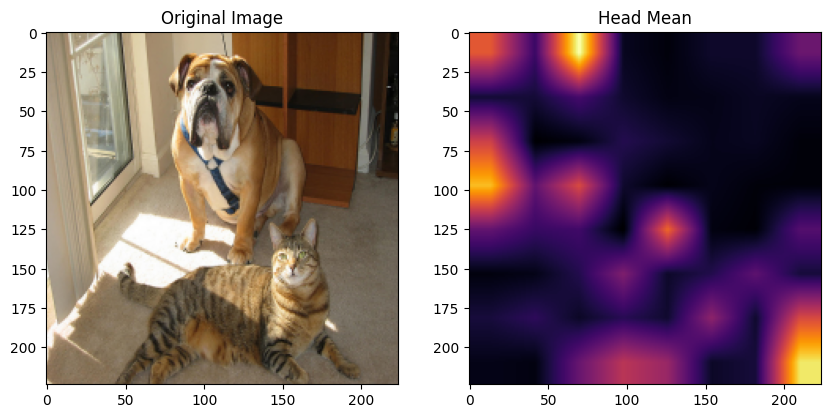

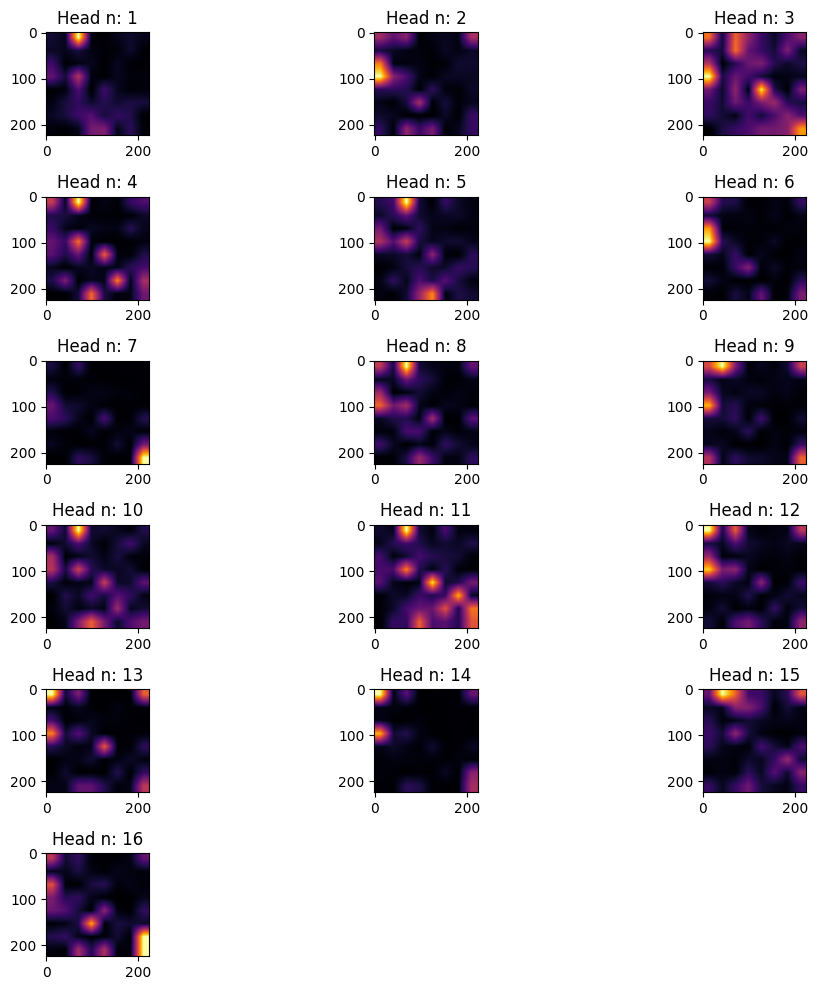

In [14]:
plot_attention(img.permute(1,2,0),show_attens)

In [ ]:
def show_each_layers(vl_attns):
    for i in range(len(vl_attns)):
        show_attens = visualize_attention(img,vl_attns[i].to(torch.float32),attn_idx,img_token_positions)
        plot_attention(img.permute(1,2,0),show_attens,idx = i)

In [ ]:
show_each_layers(vl_attns)

**二、visual-model的注意力图**

In [15]:
print(last_vit_attn.shape)

torch.Size([1, 16, 256, 256])


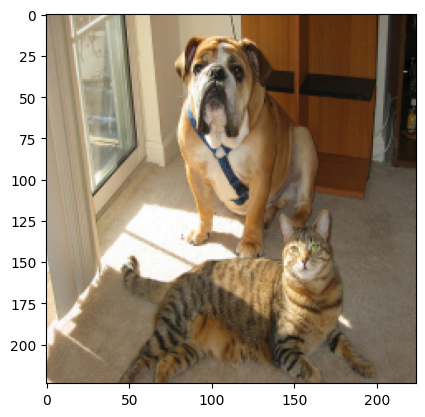

In [16]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# img = cv2.resize(img,(448,448))
img = torch.tensor(img).permute(2,0,1)
plt.imshow(img.permute(1,2,0))

In [17]:
# 预处理
patch_size = 14
# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
    img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)
w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size
nh = last_vit_attn.shape[1]  # number of head

print(w_featmap,h_featmap)
print(w,h)
print(nh)

16 16
224 224
16


(16, 224, 224)
256
attn is:0
0th finish!
attn is:1
1th finish!
attn is:2
2th finish!
attn is:3
3th finish!
attn is:4
4th finish!
attn is:5
5th finish!
attn is:6
6th finish!
attn is:7
7th finish!
attn is:8
8th finish!
attn is:9
9th finish!
attn is:10
10th finish!
attn is:11
11th finish!
attn is:12
12th finish!
attn is:13
13th finish!
attn is:14
14th finish!
attn is:15
15th finish!
attn is:16
16th finish!
attn is:17
17th finish!
attn is:18
18th finish!
attn is:19
19th finish!
attn is:20
20th finish!
attn is:21
21th finish!
attn is:22
22th finish!
attn is:23
23th finish!
attn is:24
24th finish!
attn is:25
25th finish!
attn is:26
26th finish!
attn is:27
27th finish!
attn is:28
28th finish!
attn is:29
29th finish!
attn is:30
30th finish!
attn is:31
31th finish!
attn is:32
32th finish!
attn is:33
33th finish!
attn is:34
34th finish!
attn is:35
35th finish!
attn is:36
36th finish!
attn is:37
37th finish!
attn is:38
38th finish!
attn is:39
39th finish!
attn is:40
40th finish!
attn is:41
41th f

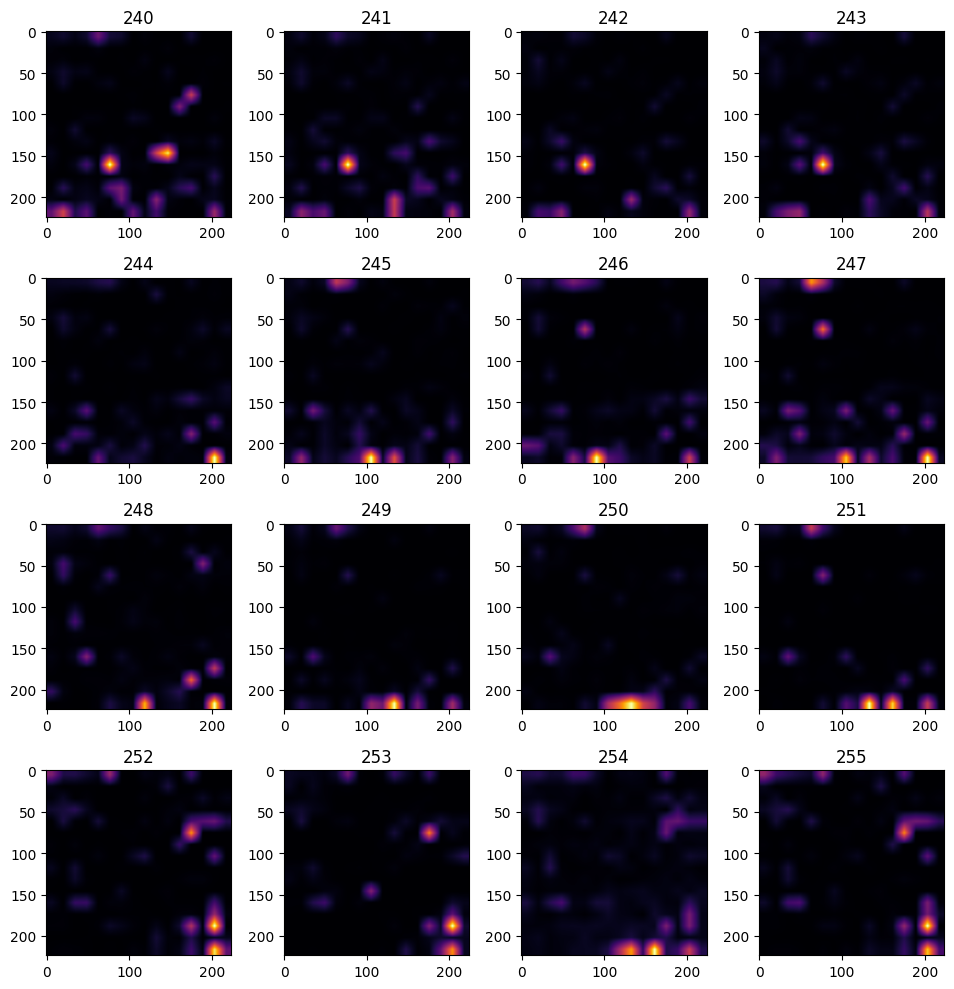

In [20]:
def get_idx_attn(attentions, idx):
    # keep only the output patch attention
    attentions = attentions[0, :, idx, :].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)

    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="bilinear")[0].cpu().detach().numpy()

    return attentions

def plot_self_attn(attention):
    plt.figure(figsize=(10, 10))

    token_nums = attention.shape[2]
    print(token_nums)
    col_nums = 4
    row_nums = 4

    attention = attention.to(torch.float32)
    for times in range(token_nums // (col_nums * row_nums)):
        offset = times * (col_nums * row_nums)
        for i in range(col_nums * row_nums):
            print(f"attn is:{i + offset}")
            self_attn = get_idx_attn(attention,i + offset)
            plt.subplot(row_nums,col_nums,i + 1)
            fig = np.mean(self_attn, 0)
            plt.imshow(fig,cmap='inferno')
            plt.title(f"{i + offset}")
            print(f"{i + offset}th finish!")
        plt.tight_layout()
        plt.savefig(f"temp/{times}.png")

demo_attn = get_idx_attn(last_vit_attn.to(torch.float32),0)
print(demo_attn.shape)
plot_self_attn(last_vit_attn)